# Expression Level of DEGs in 24h dNipBL mESCs and proximity to ChIP features

***Purpose:*** Plotting distance from promoter of DEGs to ChIP signal to see relationship between proximity of the chromatin-interacting proteins and differential expression.

* Cumulative portion of genes relative to TSS
* Concentration of CTCF peaks within a TAD compared to DEGs

In [150]:
import plotting_histogram_functions as pfn
import filter_gene_functions as flt

In [151]:
# ignore FutureWarnings generated by pandas
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas as pd
import numpy as np
import bioframe as bf
from gtfparse import read_gtf
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load data and project files

- dNipbL dataset 
- ChIP .bed files

In [152]:
proj = "/project/fudenber_735/collaborations/karissa_2022/20220812_EA18-1_RNAseq-Analysis_forGeoff/"
# Importing day 1 depletion in ESCs DEGS
day1_sigRes = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_resSig_ESC_1d-depletion.csv'
vst_normalized_counts = 'EA18.1_ESC_1d-depletion_DESeq2/20220817_EA18-1_ESC-1d_sf-normalized_vst-transformed.csv'
WT_samples = ['KHRNA1', 'KHRNA7', 'KHRNA13', 'KHRNA22', 'KHRNA23', 'KHRNA50']

# import results table and add normalized feature counts to label non-significant genes
day1_res_df = pd.read_csv(proj+day1_sigRes)
vst_counts_df = pd.read_csv(proj+vst_normalized_counts).rename(columns={'Unnamed: 0' : 'Geneid'})
vst_counts_df['avg_vst_counts'] = vst_counts_df[WT_samples].mean(axis='columns')
day1_res_df = day1_res_df.merge(vst_counts_df[['Geneid', 'avg_vst_counts']], how='outer')

# Getting TSSEs
tss_df = read_gtf("/project/fudenber_735/collaborations/karissa_2022/old/RNAseq/STAR_Gencode_alignment/tss_annotions_gencode.vM23.primary_assembly.gtf")
ts_intervals = flt.get_tss_gene_intervals(tss_df)

# labelling our dataset
day1_res_df = day1_res_df.merge(ts_intervals, left_on='Geneid', right_on='gene_id', how='left')

# If could not find a TSS, drop entire row
day1_res_df.dropna(subset=['start'], inplace=True)

# Remove any genes mapped to chrX before proceeding --> save these for later analysis
day1_res_df = day1_res_df[~day1_res_df.chrom.isin(['chrX'])]
day1_res_df = bf.sanitize_bedframe(day1_res_df)

INFO:root:Extracted GTF attributes: ['gene_id', 'transcript_id', 'gene_type', 'gene_name', 'transcript_type', 'transcript_name', 'level', 'transcript_support_level', 'mgi_id', 'tag', 'havana_gene', 'havana_transcript', 'protein_id', 'ccdsid', 'ont']


In [153]:
# Add the differential expression status for filtering genes
day1_res_df = flt.label_DE_status(day1_res_df)

In [154]:
# Load Chip-Seq files 
chip_folder = "/project/fudenber_735/collaborations/karissa_2022/2022_09_features_for_RNAseq/ChIP-seq_in_WT-parental-E14/"

ctcf = "CTCF_peaks_called_on_4reps_foundInatLeast2reps_noBlacklist.bed"
rad21 = "RAD21_peaks_called_on_6reps_foundInatLeast3reps_noBlacklist.bed"
nipbl = "Nipbl_112.175.197.114.177.196_peaks.xls.bed"
promoter = "H3K27ac_EA92-97_peaks.xls.bed"

chip_peaks_condition_dict = {'CTCF' : chip_folder+ctcf, 'RAD21' : chip_folder+rad21,
                           'NIPBL' : chip_folder+nipbl, 'H3K27ac' : chip_folder+promoter}

### Annotate distance to ChIP peak



In [155]:
# Annotate df with distance to each peak
for (chip, file) in chip_peaks_condition_dict.items():
    peaks = flt.get_peak_bioframe(file)
    day1_res_df = flt.label_closest_peak(day1_res_df, peaks, chip)

In [204]:
# set counts threshold to 6.0
cutoff = 6.0
cut = (day1_res_df['avg_vst_counts'] > cutoff)
day1_res_df = day1_res_df[cut]

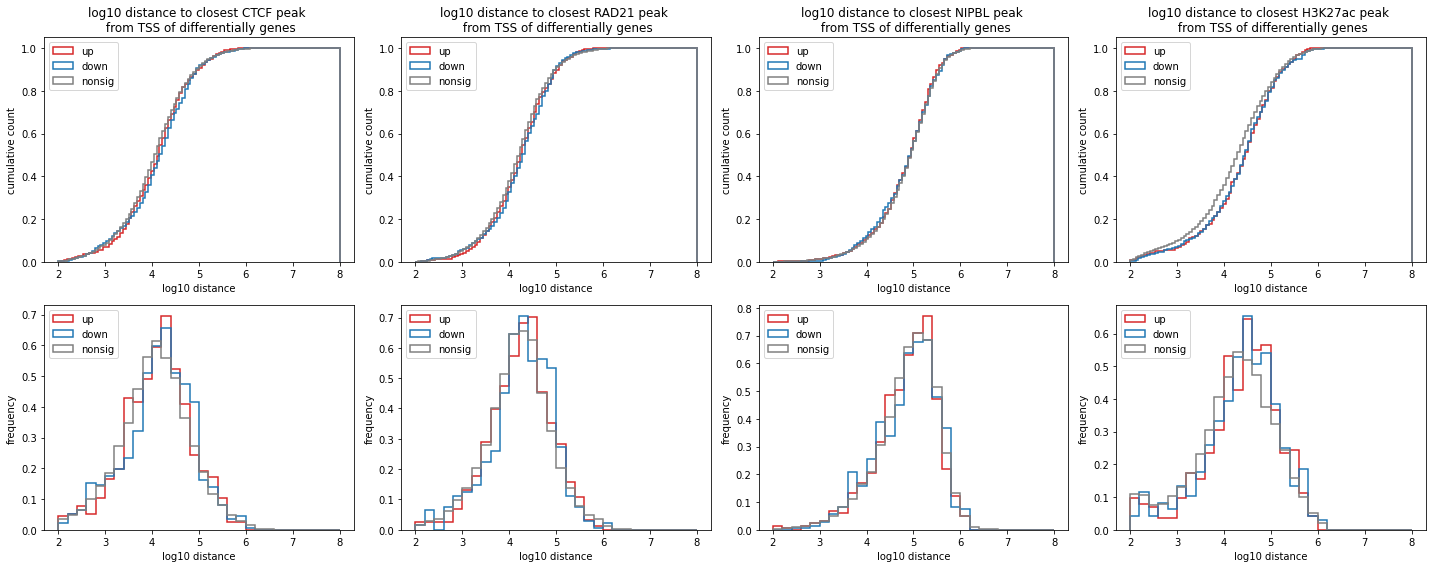

In [206]:
fig, axs = plt.subplots(2, len(chip_peaks_condition_dict), figsize=(20, 8))

for (chip_name, file), axi in zip(chip_peaks_condition_dict.items(), np.arange(axs.shape[1])):
    pfn.plot_distance_histogram(day1_res_df, 
                                 chip_name+'_distance', 
                                 ax=axs[0, axi],
                                 cumulative=True,
                                 bins=100,
                                 plot_title='log10 distance to closest {} peak \n from TSS of differentially genes'.format(chip_name))
    
    pfn.plot_distance_histogram(day1_res_df, 
                                chip_name+'_distance', 
                                ax=axs[1, axi],
                                bins=30)
    
plt.tight_layout()
plt.show()

# Concentration of CTCF within TADs of DEG

In [176]:
feature_dir = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features'
insulation_table = pd.read_table(feature_dir+'/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation')

In [177]:
# Break up the categories into quantiles according ot vst_counts
quantiled_df = day1_res_df.copy()

quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts")
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='up')
quantiled_df = flt.label_quantiles(quantiled_df, quantile_value_col="avg_vst_counts", label_subset='down')

# set counts threshold to 6.0
cutoff = 6.0
cut = (quantiled_df['avg_vst_counts'] > cutoff)
quantiled_df = quantiled_df[cut]

In [193]:
category_colormap_big = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',

                         'nonsig_0.0-0.5' : '#d9d9d9',
                         'nonsig_0.5-0.75' : '#bdbdbd',
                         'nonsig_0.75-0.95' : '#969696',
                         'nonsig_0.95-1.0' : '#636363'
                        }

category_colormap_degs = {'up_0.0-0.5' : '#fee5d9',
                         'up_0.5-0.75' : '#fcae91',
                         'up_0.75-0.95' : '#fb6a4a',
                         'up_0.95-1.0' : '#cb181d',

                         'down_0.0-0.5' : '#deebf7',
                         'down_0.5-0.75' : '#bdd7e7',
                         'down_0.75-0.95' : '#6baed6',
                         'down_0.95-1.0' : '#2171b5',
                        }

/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py:269: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  continue


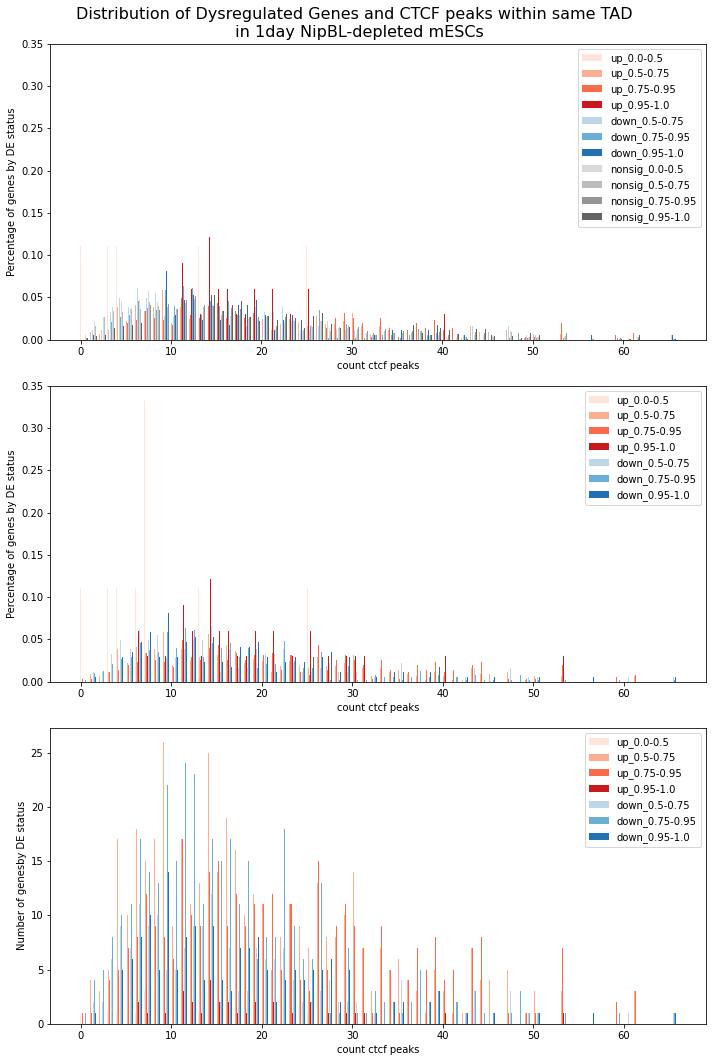

In [213]:
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_peaks',
                                    ax=axs[0]
                                   )

pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_degs,
                                    region_group_col='count_ctcf_peaks',
                                    ax=axs[1]
                                   )

pfn.group_features_by_region(df,
                             quantiled_df,
                             feature_category_colors=category_colormap_degs,
                             region_group_col='count_ctcf_peaks',
                             ax=axs[2]
                            )
    
plt.tight_layout()
plt.show()

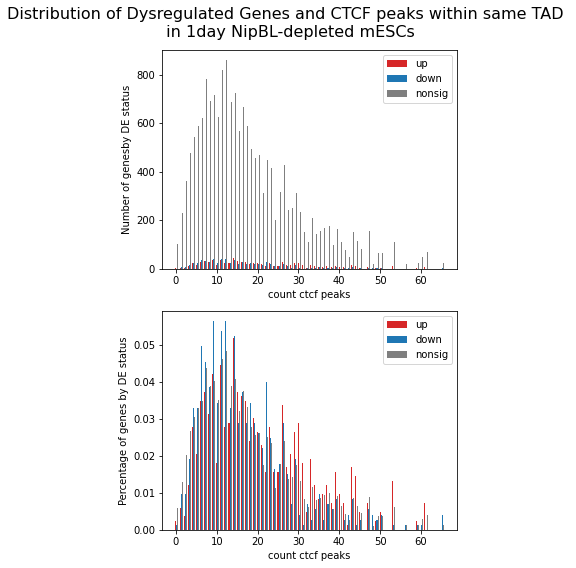

In [226]:
fig, axs = plt.subplots(2, 1, figsize=(5, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# Defining TADs using midpoints between boundaries
tad_mid_df = flt.tad_windows_from_boundaries(insulation_table, take_midpoint=True)

# Annotate number of CTCF within the tad
df = tad_mid_df.copy()
ctcf_df = flt.get_peak_bioframe(chip_peaks_condition_dict['CTCF'])
df['count_ctcf_peaks'] = bf.count_overlaps(df, ctcf_df)['count']

pfn.group_features_by_region(df,
                             day1_res_df,
                             region_group_col='count_ctcf_peaks',
                             ax=axs[0]
                            )

pfn.distribution_features_by_region(df,
                             day1_res_df,
                             region_group_col='count_ctcf_peaks',
                             ax=axs[1]
                            )

    
plt.tight_layout()
plt.show()

Grouping into bins to see a little better :D 

In [ ]:
# Assign bins for ctcf counts to group them
df = pfn.assign_bin(df, 'count_ctcf_peaks', np.arange(0, 70, 5), 'count_ctcf_bin')


/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py:335: UserWarning: category down_0.0-0.5 is empty, skipped in plotting
  warnings.warn(


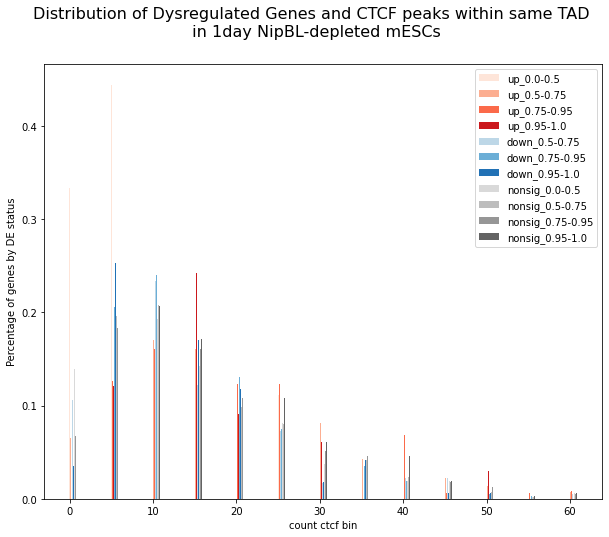

In [237]:
fig, axs = plt.subplots(1, 1, figsize=(10, 8))
fig.suptitle(('Distribution of Dysregulated Genes and '
             'CTCF peaks within same TAD \n in 1day NipBL-depleted mESCs'),
             fontsize=16)

# plot
pfn.distribution_features_by_region(df,
                                    quantiled_df,
                                    feature_category_colors=category_colormap_big,
                                    region_group_col='count_ctcf_bin',
                                    ax=axs
                                   )

In [190]:
# Add column to gene df with the count of ctcfs
day1_res_df['count_ctcf_within_tad'] = bf.overlap(day1_res_df, df, how='inner', suffixes=('_genes', '_tads'))['count_ctcf_peaks_tads']

quantiled_df['count_ctcf_within_tad'] = bf.overlap(quantiled_df, df, how='inner', suffixes=('_genes', '_tads'))['count_ctcf_peaks_tads']

In [214]:
import importlib
importlib.reload(pfn)

<module 'plotting_histogram_functions' from '/home1/pokorny/transcription_3Dfolding/transcription_3dfolding/transcription_data_analysis/plotting_histogram_functions.py'>

/tmp/SLURM_9405801/ipykernel_51305/252656122.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pfn.plot_count_histogram(day1_res_df[cut],
/tmp/SLURM_9405801/ipykernel_51305/252656122.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pfn.plot_count_histogram(day1_res_df[cut],
/tmp/SLURM_9405801/ipykernel_51305/252656122.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pfn.plot_count_histogram(quantiled_df[cut],
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges
/tmp/SLURM_9405801/ipykernel_51305/252656122.py:25: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pfn.plot_count_histogram(quantiled_df[cut],
/home1/pokorny/.conda/envs/bioenv/lib/python3.9/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encou

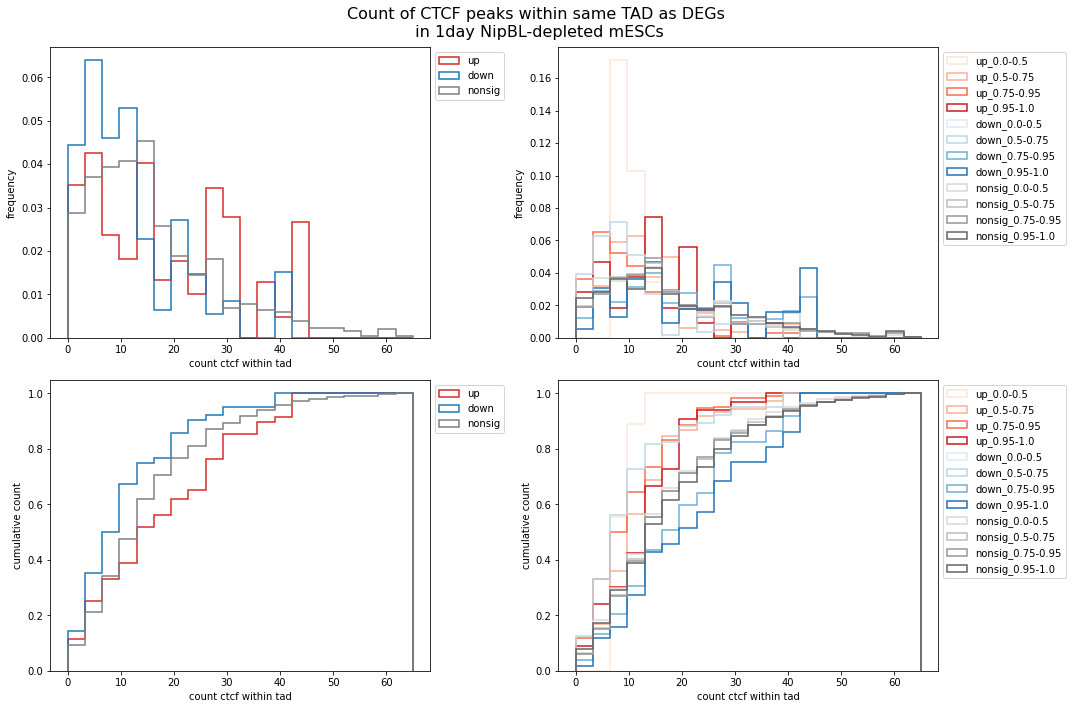

In [215]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle(('Count of CTCF peaks within same TAD as DEGs'
             '\n in 1day NipBL-depleted mESCs'),
             fontsize=16)

pfn.plot_count_histogram(day1_res_df[cut],
                     'count_ctcf_within_tad',
                    cumulative=True,
                     bins=20,
                    ax=axs[1, 0])

pfn.plot_count_histogram(day1_res_df[cut],
                     'count_ctcf_within_tad',
                    cumulative=False,
                    bins=20,
                    ax=axs[0, 0])

pfn.plot_count_histogram(quantiled_df[cut],
                     'count_ctcf_within_tad',
                     category_colors=category_colormap_big,
                    cumulative=True,
                     bins=20,
                    ax=axs[1, 1])

pfn.plot_count_histogram(quantiled_df[cut],
                     'count_ctcf_within_tad',
                     category_colors=category_colormap_big,
                     cumulative=False,
                     bins=20,
                     ax=axs[0, 1])

plt.tight_layout()
plt.show()

In [172]:
day1_res_df[cut]['DE_status'].value_counts()

nonsig    17791
up          831
down        727
Name: DE_status, dtype: int64

In [174]:
quantiled_df.loc[cut]['DE_status'].value_counts()

nonsig_0.5-0.75     8084
nonsig_0.75-0.95    6241
nonsig_0.0-0.5      1928
nonsig_0.95-1.0     1538
up_0.5-0.75          441
down_0.75-0.95       375
up_0.75-0.95         348
down_0.5-0.75        181
down_0.95-1.0        171
up_0.95-1.0           33
up_0.0-0.5             9
Name: DE_status, dtype: int64